# Exploratory and Cluster Analysis of 2020/2022 Company Layoff Data


In light of recent tech layoffs, this project aims to spot trends within the layoff data between the 2 periods in time. This dataset is taken from [Kaggle](https://www.kaggle.com/datasets/swaptr/layoffs-2022), and is a record of layoff data from 11 March 2020 to 14 December 2022. Layoffs during 2020 in the tech sector is most largely attributed towards economic slowdowns due to the impacts of COVID-19, whereas the slowdown in 2022 is seen in tandem with higher interest rates and slowing consumer spending. Clustering layoff activity between these 2 cohorts for US-based companies will potentially provide us a macro view of what sectors, locations and types of tech companies were impacted by the layoffs.

## Data Cleaning

In [887]:
import numpy as np
import pandas as pd
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import datetime as dt
import scipy as sp
from sklearn import preprocessing
from kmodes.kprototypes import KPrototypes
from IPython.display import display, HTML
from kneed import KneeLocator
from sklearn.preprocessing import StandardScaler
warnings.filterwarnings('ignore')

df = pd.read_csv('/Users/ethan/Downloads/layoffs.csv')
df['date'] = pd.to_datetime(df['date'])
print(df.isna().sum())
print(df.dtypes)



company                  0
location                 0
industry                 3
total_laid_off         505
percentage_laid_off    562
date                     0
stage                    4
country                  0
funds_raised           123
dtype: int64
company                        object
location                       object
industry                       object
total_laid_off                float64
percentage_laid_off           float64
date                   datetime64[ns]
stage                          object
country                        object
funds_raised                  float64
dtype: object


We shall import the dataset, which is originally extracted from Kaggle. We see that there are a number of NA values with a majority of them in the total_laid_off, percentage_laid_off columns and funds_raised. For the purpose of our analysis we shall omit records that contain NA values for these columns, as we wish to cluster layoff data based on these metrics. 

In [888]:
na_values = df['percentage_laid_off'].isna() | df['total_laid_off'].isna() | df['industry'].isna() | df['funds_raised'].isna()
df = df[(~na_values)]
print(df.isna().sum())
df.to_clipboard()

company                0
location               0
industry               0
total_laid_off         0
percentage_laid_off    0
date                   0
stage                  0
country                0
funds_raised           0
dtype: int64


## Exploratory Data Analysis

We shall investigate the distribution of single instances of lay offs per Country in terms of the headcount that were affected by them. From this point onwards, we will conduct our analysis in a stratified view between layoffs in 2020 and 2022 so far. 

['United States', 'Indonesia', 'Argentina', 'India', 'United Kingdom', 'Australia', 'Germany', 'Brazil', 'Canada', 'Nigeria', 'Singapore', 'Sweden', 'Ireland', 'Kenya', 'Estonia', 'Israel', 'Norway', 'Denmark', 'Thailand', 'Senegal', 'Hong Kong', 'China', 'United Arab Emirates', 'Austria', 'Finland', 'Malaysia', 'Mexico', 'Russia', 'Seychelles', 'Netherlands', 'Switzerland', 'Portugal']


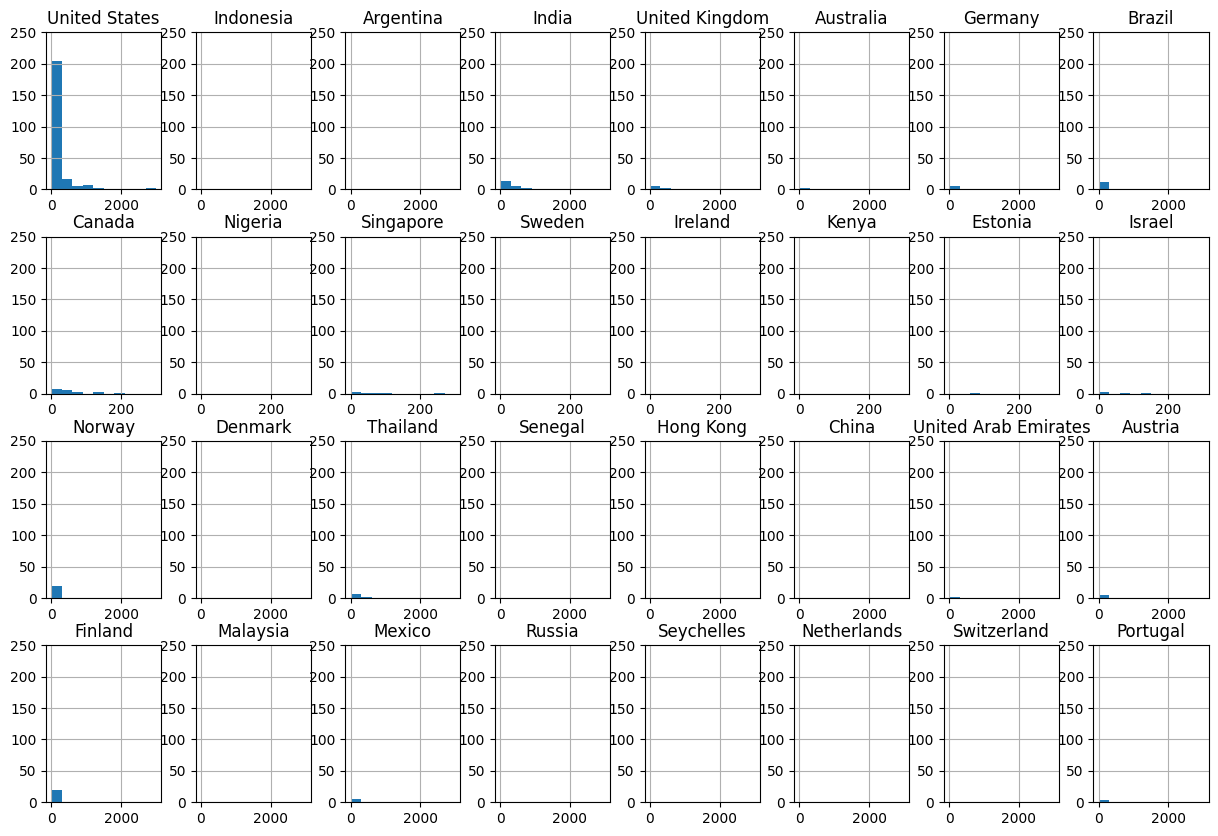

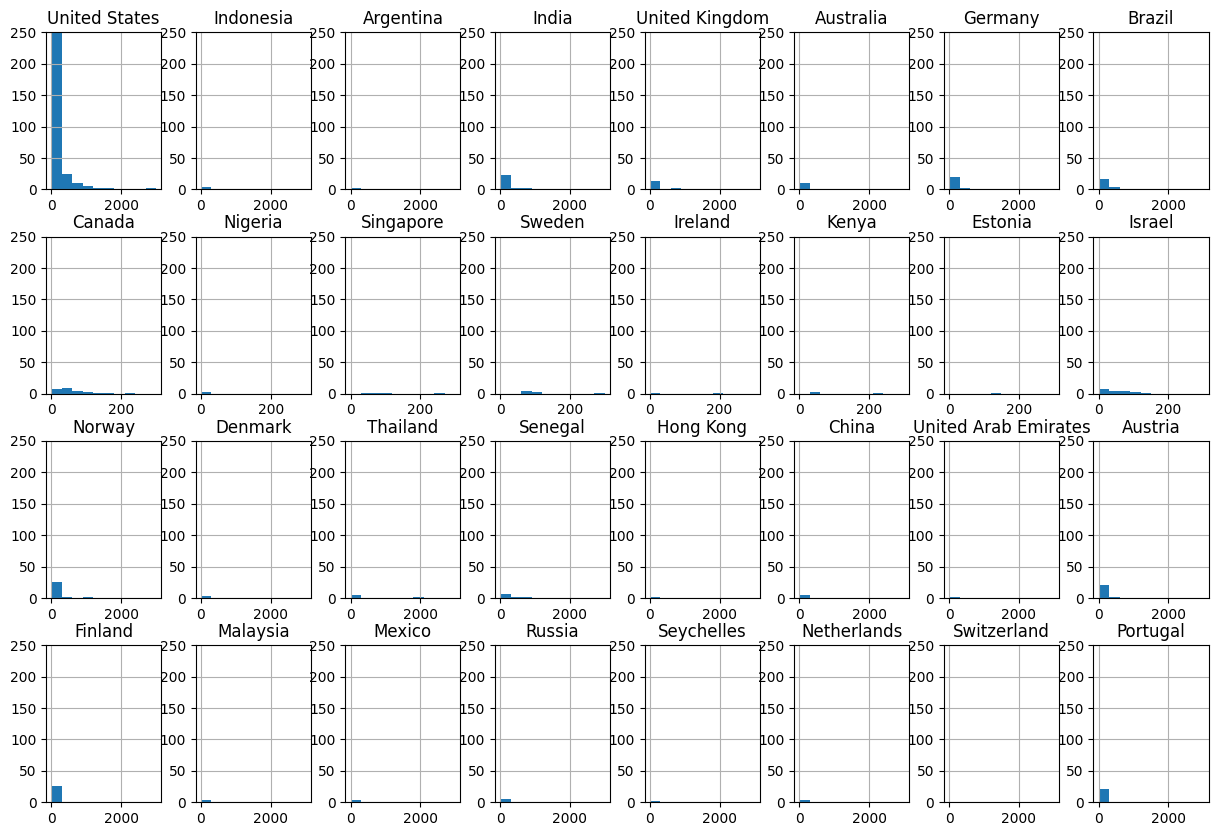

In [889]:
df = df[['country','location', 'industry', 'stage', 'company', 'total_laid_off', 'percentage_laid_off', 'funds_raised', 'date']]
print(df['country'].unique().tolist())
countries = df['country'].unique()
pd.Series(countries)

for i in range(2020,2023,2):   
    df1 = df[(df['date'].dt.year ==int(i))] 
    fig, ax = plt.subplots(4,8, figsize=(15,10))
    fig.tight_layout(pad=40)
    for i in range(8): 
        df1[df1['country'] == countries[i]].hist(ax = ax[0,i],column=["total_laid_off"], figsize=(50,50),range = [0,3000])
        ax[0,i].set_title("%s" %(countries[i]))
        ax[0,i].set_ylim([0, 250])
    for i in range(8): 
        df1[df1['country'] == countries[i+8]].hist(ax = ax[1,i],column=["total_laid_off"], figsize=(50,50),range = [0,300])
        ax[1,i].set_title("%s" %(countries[i+8]))
        ax[1,i].set_ylim([0, 250])
    for i in range(8): 
        df1[df1['country'] == countries[i+8]].hist(ax = ax[2,i],column=["total_laid_off"], figsize=(50,50),range = [0,3000])
        ax[2,i].set_title("%s" %(countries[i+16]))
        ax[2,i].set_ylim([0, 250])
    for i in range(8): 
        df1[df1['country'] == countries[i+8]].hist(ax = ax[3,i],column=["total_laid_off"], figsize=(50,50),range = [0,3000])
        ax[3,i].set_title("%s" %(countries[i+24]))
        ax[3,i].set_ylim([0, 250])

We see that a majority of the layoff data, is concentrated in the United States. We shall therefore focus on our view to specifically within the United States. This will help us avoid misleading interpretation of results later in the project, when we cluster our data with location as a variable. 

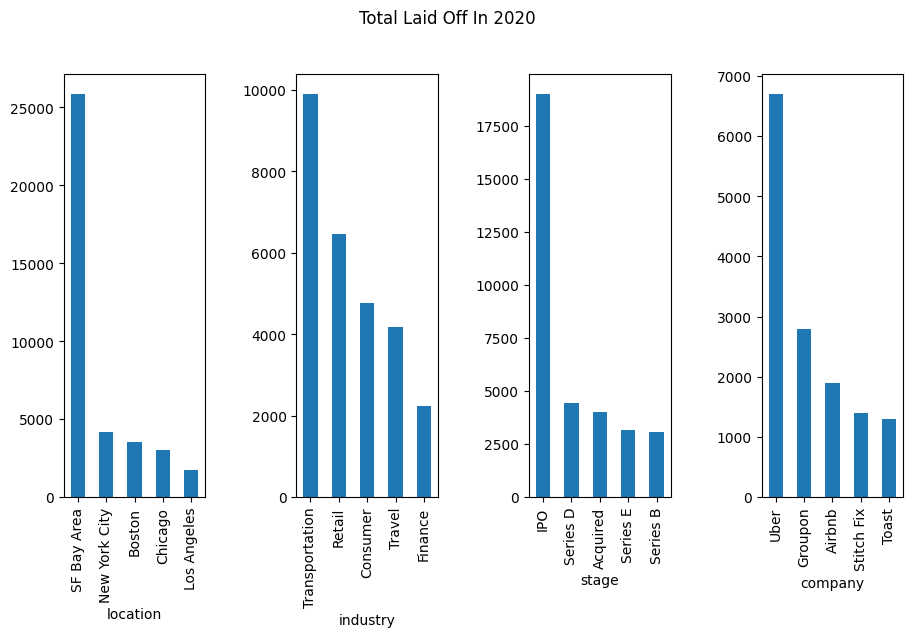

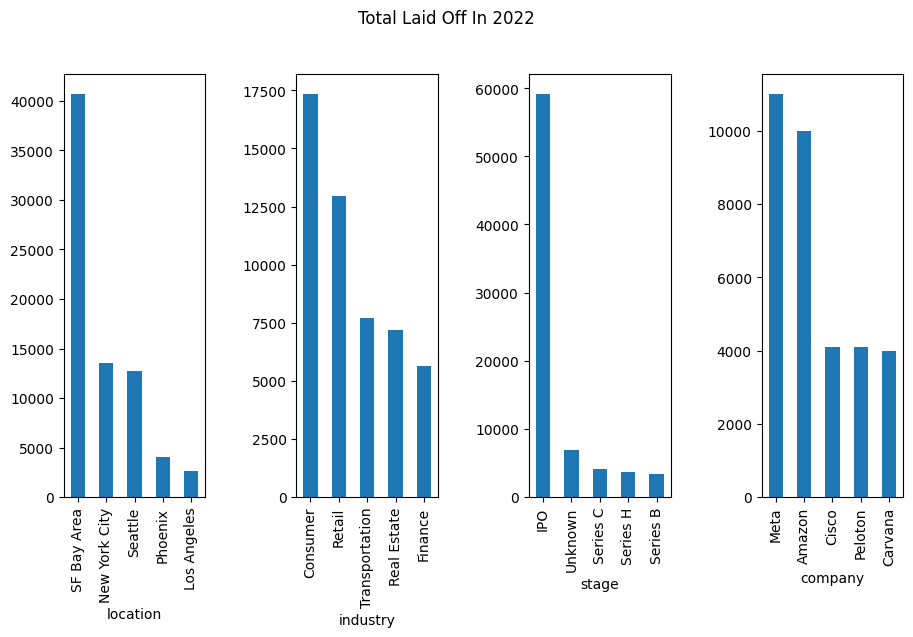

In [890]:
for i in range(2020,2023,2):
    df1 = df[(df['date'].dt.year ==int(i)) & (df['country'] == 'United States')] 
    df1 = df1.drop({'date','country'}, axis=1)
    fig, ax = plt.subplots(1,4, figsize=(20,20))
    fig.tight_layout(pad=10)
    plt.title("Total Laid Off In %s " %(i), x = -2.2, y= 1.1,fontsize=12, loc='center')
    for i in range(4): 
        group = df1.groupby(df1.iloc[:,i])['total_laid_off'].sum()
        group = pd.DataFrame(group)
        group = group.nlargest(5, 'total_laid_off')
        group.plot(ax = ax[i],kind='bar', y= 'total_laid_off', legend=None, figsize=(10,5))


In 2020, we see that a bulk of lay-offs happened in metropolitan areas such as Los Angeles, NYC, SF Bay Area, Boston and Chicago. A similar narrative is told in the lay-offs by location in 2022 with the inclusion of Phoenix. We can infer that this is due mainly to the layoffs from Carvana, a company based in Arizona that is also within the top 5 companies in terms of total layoffs for 2022. 

Consumer, Retail and Transportation were industries that saw a majority of layoffs for technology firms both in 2020 and 2022. This is expected as economic slowdowns generally constitute lower consumer spending. In 2020, both travel and transportation saw large numbers of layoffs which reflect the impacts of global shutdowns during the time. 2022 saw noticeable ayoff activity in real estate which is possibly in correlation to a higher interest rate environment. 

The general trend we can extract from layoffs according to the funding series the company is currently at, is that a higher number of layoffs occur the later stages of funding. Series A funding denotes the stage at which the company intends to further growth through equity financing from venture capital investors. This stage requires company valuation figures, and a documented track record of revenue growth and company performance. The subsequent rounds, (B, C, D, etc.) are intended to push companies past the development and into mass market strategies to fully capture its potential customer base.  Therefore, we see that public companies with larger financing show the most predominant layoff activity in both years. Series B is the earliest stage seen in the top 5 stages by total layoffs, and thus higher layoffs are commonly associated with later stages of funding for technology firms. 

Uber saw the largest layoffs in 2020, in line with the highly affected transportation sector that year. There are also 2 e-commerce companies in the top 5, Groupon and Stitch Fix which could be indicative of restructuring that e-commerce companies that gone through to accomodate for higher demand during the time. This goes to show that layoff activity and factors for layoffs are not universal across large technology firms. Not shown in the 2020 graph, the e-commerce giant Amazon saw jobs being added during the 2020 period. Inversely, we see that Amazon and Meta are in the top 5 category for 2022 along with Cisco, Carvana and Peloton. Amazon being in the top 5 provides the insight of a market correction from the surge in demand during the post-Covid boom. 

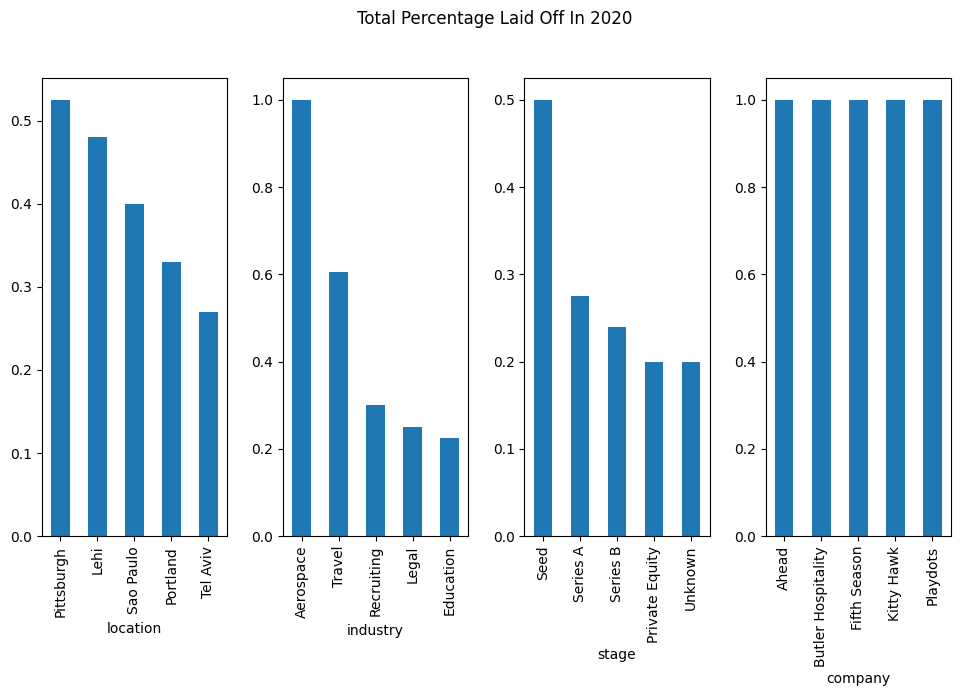

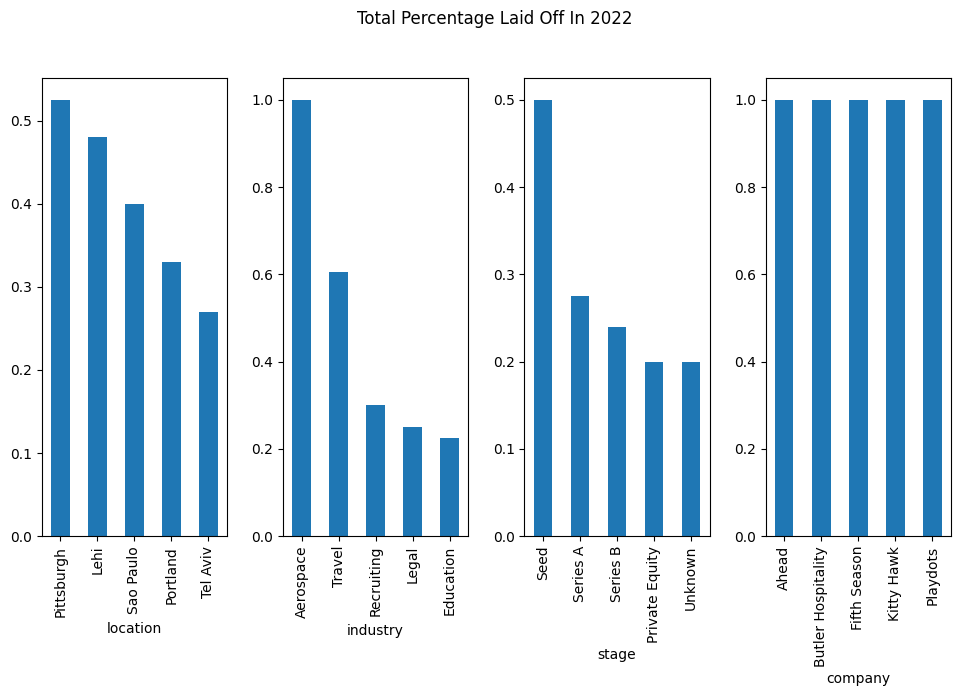

In [891]:
for i in range(2020,2023,2):   
    fig, ax = plt.subplots(1,4, figsize=(20,20))
    fig.tight_layout(pad=5)
    plt.title("Total Percentage Laid Off In %s " %(i), x = -1.45, y= 1.1, loc="center",fontsize=12)
    for i in range(4): 
        group = df1.groupby(df1.iloc[:,i])['percentage_laid_off'].median()
        group = pd.DataFrame(group)
        group = group.nlargest(5, 'percentage_laid_off')
        group.plot(ax = ax[i], kind='bar', y= 'percentage_laid_off', legend=None, figsize=(10,5))

Speaking in terms of the relative proportion of the employees laid off to the total company headcount, we see that the largest median percentage laid off typically occur in areas that are not within the areas that gross the highest tech employment growth rates such as San Franciso, Boston, Seattle, NYC or Los Angeles. The reason behind non-American cities such as Sao Paulo and Tel Aviv being reported is due to US-based companies laying off branches overseas. The industries - Aerospace, Travel, Recruiting, Legal and Education have contituted the top 5 percentage of layoffs for 2022. 

We see that there is also a distinction between the relative median percentage of layoffs and absolute total layoffs in terms of of where it shows the most activity across funding stages. As opposed to total absolute number of layoffs occuring in later stages, earlier stages such as Seed and Series A rounds have relatively higher median percentage of layoffs to total headcount - which stands to say that on a 50th percentile, a larger portion of the workforce for companies in earlier funding stages are laid off as compared to companies in later stages possibly due to lower headcount. 

All the companies in the top 5 percentage laid off had their entire workforce cut in 2022, showing us that they have stopped their operations completely.  



In [892]:
df_industry  = df[(df['country'] == 'United States') & ((df['industry'] =='Aerospace') | (df['industry'] == 'Travel') | (df['industry'] == 'Recruiting') | (df['industry'] == 'Legal') | (df['industry'] == 'Education'))]
df_industry['industry'].value_counts()
df[(df['country'] == 'United States') & ((df['industry'] =='Aerospace') | (df['industry'] =='Legal'))]

,country,location,industry,stage,company,total_laid_off,percentage_laid_off,funds_raised,date
321,United States,SF Bay Area,Aerospace,Unknown,Kitty Hawk,100.0,1.00,1.0,2022-09-21
810,United States,Boston,Legal,Series D,Notarize,110.0,0.25,213.0,2022-06-15
1458,United States,Atlanta,Legal,Series B,OneTrust,150.0,0.10,410.0,2020-04-09
1518,United States,SF Bay Area,Aerospace,Unknown,Astra,40.0,0.25,100.0,2020-04-05


We see that the median percentage of employees laid off per industry must be addressed with caution for the Aerospace and Legal sectors, the median 100% layoff shown for Aerospace is skewed due to a miniscule sample population size. 

We shall investigate further the relationship between the company funding and layoff size. The correlation between the total funding raised and total number of employees laid off could provide insights. 

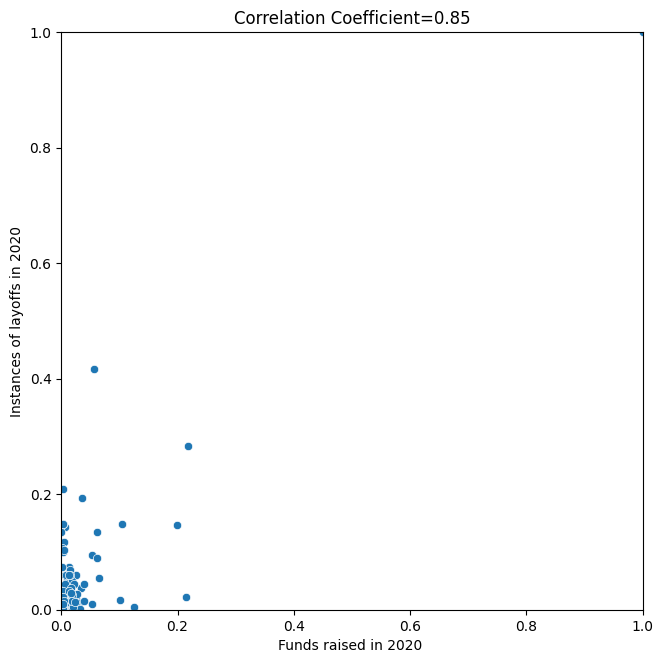

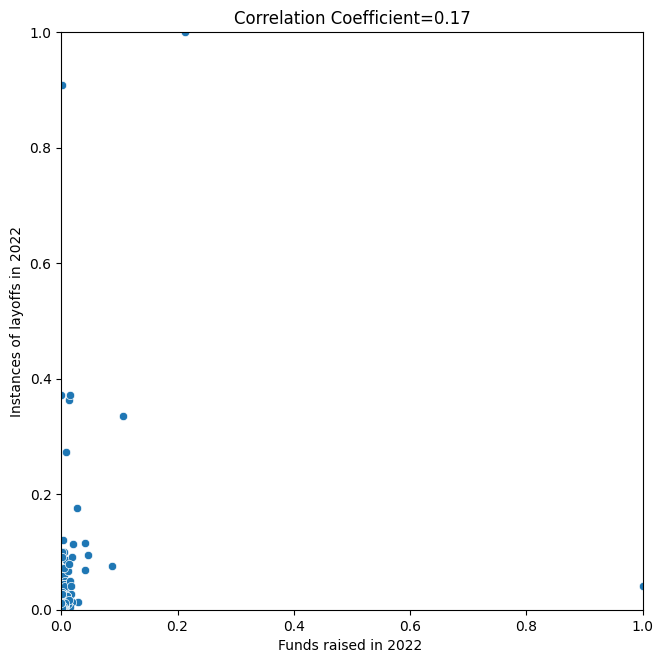

In [893]:
for i in range(2020,2023,2):
    df1 = df[(df['date'].dt.year ==int(i)) & (df['country'] == 'United States')] 
    Scaler = preprocessing.MinMaxScaler()
    df1 = df1.groupby('company').agg(
    {
        'location': lambda x: x.value_counts().index[0],
        'industry': lambda x: x.value_counts().index[0],
        'stage': lambda x: x.value_counts().index[0],
        'total_laid_off': 'sum',
        'percentage_laid_off': 'median',
        'funds_raised': 'max'
    }
    ).reset_index()
    df1['funds_raised']=Scaler.fit_transform(X= np.array(df1['funds_raised']).reshape(-1,1))
    df1['total_laid_off']=Scaler.fit_transform(X= np.array(df1['total_laid_off']).reshape(-1,1))
    df1['percentage_laid_off']=Scaler.fit_transform(X= np.array(df1['percentage_laid_off']).reshape(-1,1))
    plt.figure(figsize=(7.5,7.5))
    ax = sns.scatterplot(x=df1['funds_raised'], y=df1['total_laid_off'], data=df1)
    ax.set_xlabel("Funds raised in %s " %(i))
    ax.set_ylabel("Instances of layoffs in %s" %(i))
    ax.set_xlim(0,1)
    ax.set_ylim(0,1)
    r, p = sp.stats.pearsonr(x = df1['funds_raised'],y=df1['total_laid_off'] )
    ax.set_title('Correlation Coefficient={:.2f}'.format(r))
    plt.show()

There is an outlier spotted in 2020 data, that have significantly higher than normal raised funds and total layoffs. This attributes greatly to a highly skewed correlation coefficient, as the remaining data points suggest otherwise a weak correlation between the total funds raised and the total layoffs.

This weak correlation is seen also in 2022, concluding that there is only a weak correlation between the amount of funds raised and the total layoffs across each company. 

There is instead a potentially stronger association between the latest funding stage at which the company has raised its funds and the total layoffs. 

## Clustering 

K-means algorithm deals with exclusively numerical data. It clusters the datasets into sub-groups, and aims to minimize the squared distance between the cluster means and the data points that are within the respective cluster. The process is detailed as follows: 
- Specify the number of clusters K. 
- Choose K random data points to be initialized as cluster centroids (cluster means) during the start of the process.
- Assign each data point to the K clusters based on the shortest squared distance. 
- Compute the new cluster centroid based on the data points in each cluster.
- This process will keep repeating until the center mean sees no more changes after an iteration.

K-modes on the other hand, deals with exclusively categorical data. Unlike continuous numerical data, we are unable to calculate the squared distance between categorical data points. Instead, we use the dissimilarity metric which is the total mismatches between each data point on their categorical variables for clustering. The less dissimilar data points are to one another, the more likely they are to be within the same cluster. The process is detailed as follows: 

- Specify the number of clusters K. 
- Choose K random data points to be initialized as the main characteristics for each cluster. These are the cluster modes.
- Calculate the dissimilarity between each data point to the cluster mode. 
- Assign each data point to the cluster that derives the data point’s lowest dissimilarity metric among all the point’s metrics for each cluster.  
- Calculate the mode of each cluster based on the newly assigned data points. 
- This process will keep repeating until the modes for each cluster no longer changes

Since we have categorical variables in our data frame as well as numerical variables, neither K-means nor K-modes would be a suitable clustering algorithm as each of these only exclusively deal with numerical and categorical data respectively. 
K-prototype is an algorithm that minimizes a cost function – that is derived from both the Euclidean distance between the numerical variables between data points, and the dissimilarity between the categorical variables. The cluster centers therefore indicate the mean value of each numerical variables, and the mode of each categorical variable. 
To find the optimal number of clusters, we will plot an elbow curve which details how the cost function metric decreases as more clusters are used.

['company', 'location', 'industry', 'stage']


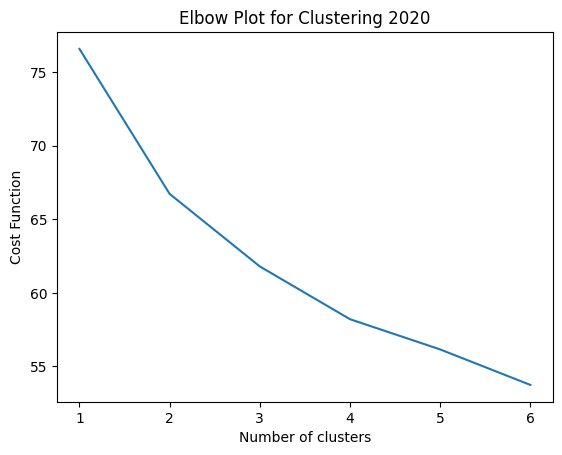

['company', 'location', 'industry', 'stage']


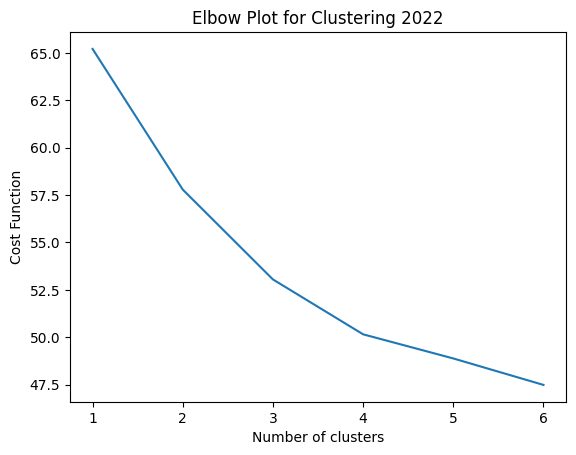

In [894]:
for i in range(2020,2023,2):
    df1 = df[(df['date'].dt.year ==int(i)) & (df['country'] == 'United States')] 
    df1 = df1.drop('date', axis=1)
    Scaler = preprocessing.MinMaxScaler()
    df1['funds_raised']=Scaler.fit_transform(X= np.array(df1['funds_raised']).reshape(-1,1))
    df1['total_laid_off']=Scaler.fit_transform(X= np.array(df1['total_laid_off']).reshape(-1,1))
    df1['percentage_laid_off']=Scaler.fit_transform(X= np.array(df1['percentage_laid_off']).reshape(-1,1))
    df1 = df1.groupby('company').agg(
    {
        'location': lambda x: x.value_counts().index[0],
        'industry': lambda x: x.value_counts().index[0],
        'stage': lambda x: x.value_counts().index[0],
        'total_laid_off': 'sum',
        'percentage_laid_off': 'median',
        'funds_raised': 'max'
    }
    ).reset_index()
    
    catColumnsPos = [df1.columns.get_loc(col) for col in list(df1.select_dtypes('object').columns)]
    print(list(df1.select_dtypes('object').columns))

    dfMatrix = df1.to_numpy()
    dfMatrix

    cost = []
    clusters = []
    for x in range(1, 7):
        try:
            kprototype = KPrototypes(n_jobs = -1, n_clusters = x, init = 'Huang', random_state = 0)
            kprototype.fit_predict(dfMatrix, categorical = catColumnsPos)
            cost.append(kprototype.cost_)
            clusters.append(x)
        except:
            break

    plt.figure()
    plt.xlabel('Number of clusters')
    plt.ylabel('Cost Function')
    plt.title('Elbow Plot for Clustering %s' %(i))
    plt.plot(clusters,  cost)
    plt.show()



The optimal number of clusters to choose, is commonly associated with the number of clusters where the cost function stops decreasing exponentially beyond that point – or where the elbow “bends”. This is a naïve method for choosing optimal clusters as our visual interpretation is required. We see that for both years, 4 clusters is the point at which the the gradient starts to flatten. We will thus use 4 clusters for both years. 

In [895]:

def clustering(i): 
    df_new = df[(df['date'].dt.year ==int(i)) & (df['country'] == 'United States')]  
    df_new = df_new.drop({'date','country'}, axis=1)
    catColumnsPos = [df_new.columns.get_loc(col) for col in list(df_new.select_dtypes('object').columns)] 
    Scaler = preprocessing.MinMaxScaler()
    df_new['funds_raised']=Scaler.fit_transform(X= np.array(df_new['funds_raised']).reshape(-1,1))
    df_new['total_laid_off']=Scaler.fit_transform(X= np.array(df_new['total_laid_off']).reshape(-1,1))
    df_new['percentage_laid_off']=Scaler.fit_transform(X= np.array(df_new['percentage_laid_off']).reshape(-1,1))
    df_new = df_new.groupby('company').agg(
        {
        'location': lambda x: x.value_counts().index[0],
        'industry': lambda x: x.value_counts().index[0],
        'stage': lambda x: x.value_counts().index[0],
        'total_laid_off': 'sum',
        'percentage_laid_off': 'median',
        'funds_raised': 'max'
        }
    ).reset_index()
    df_new = df_new.drop('company', axis=1)
    kprototype = KPrototypes(n_jobs = -1, n_clusters = 4, init = 'Huang', random_state = 0)
    kprototype.fit_predict(df_new, categorical = catColumnsPos)
    df_new['Cluster Labels'] = kprototype.labels_
    return df_new

We will create a function to automate the process of standardizing, grouping by company, and clustering each year's data into 4 clusters. We do this, to be able to more easily create side-by-side visuals of cluster characteristics between years. 

2    75
1    70
0    65
3    23
Name: Cluster Labels, dtype: int64


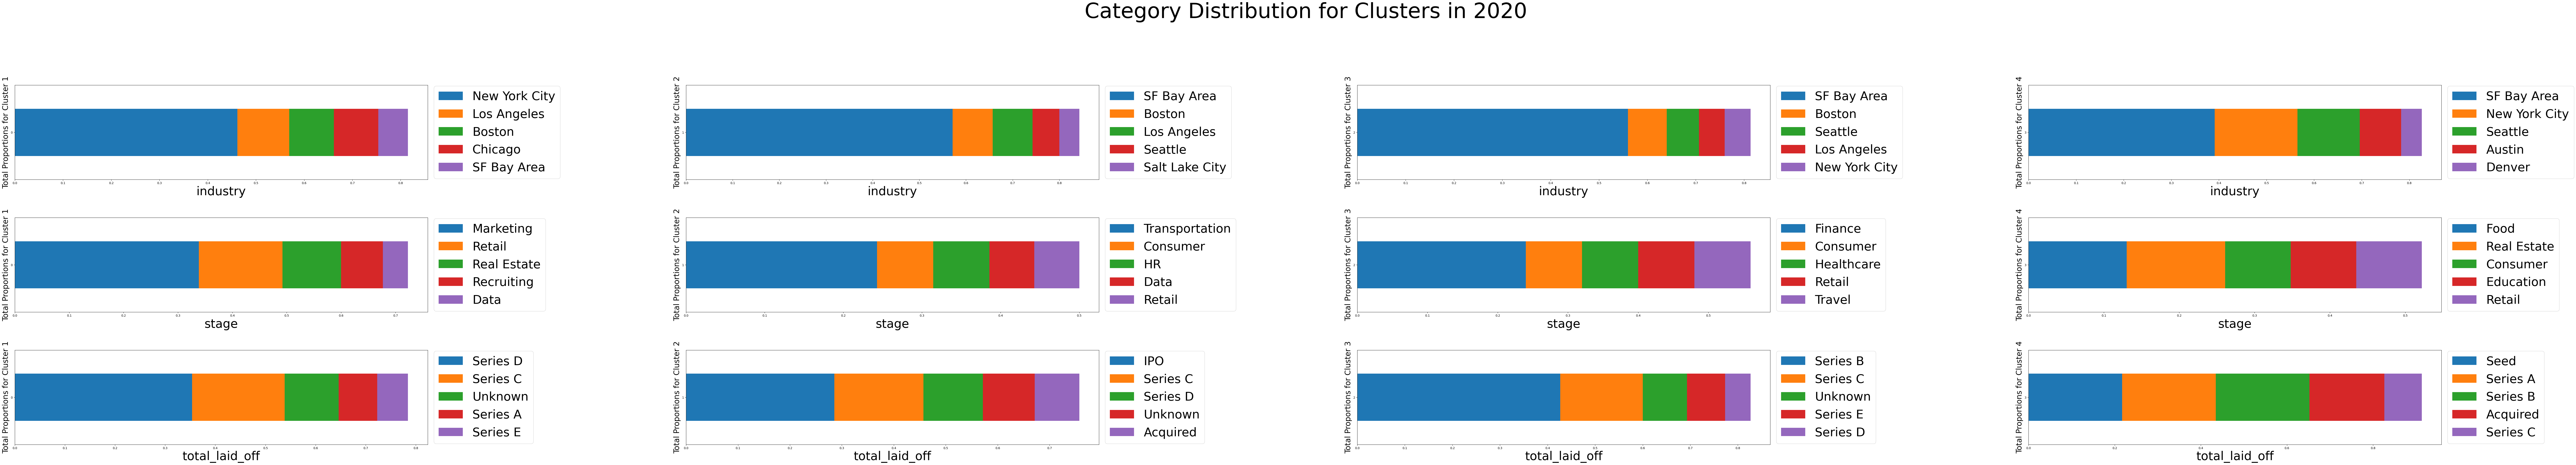

3    99
0    93
2    72
1    12
Name: Cluster Labels, dtype: int64


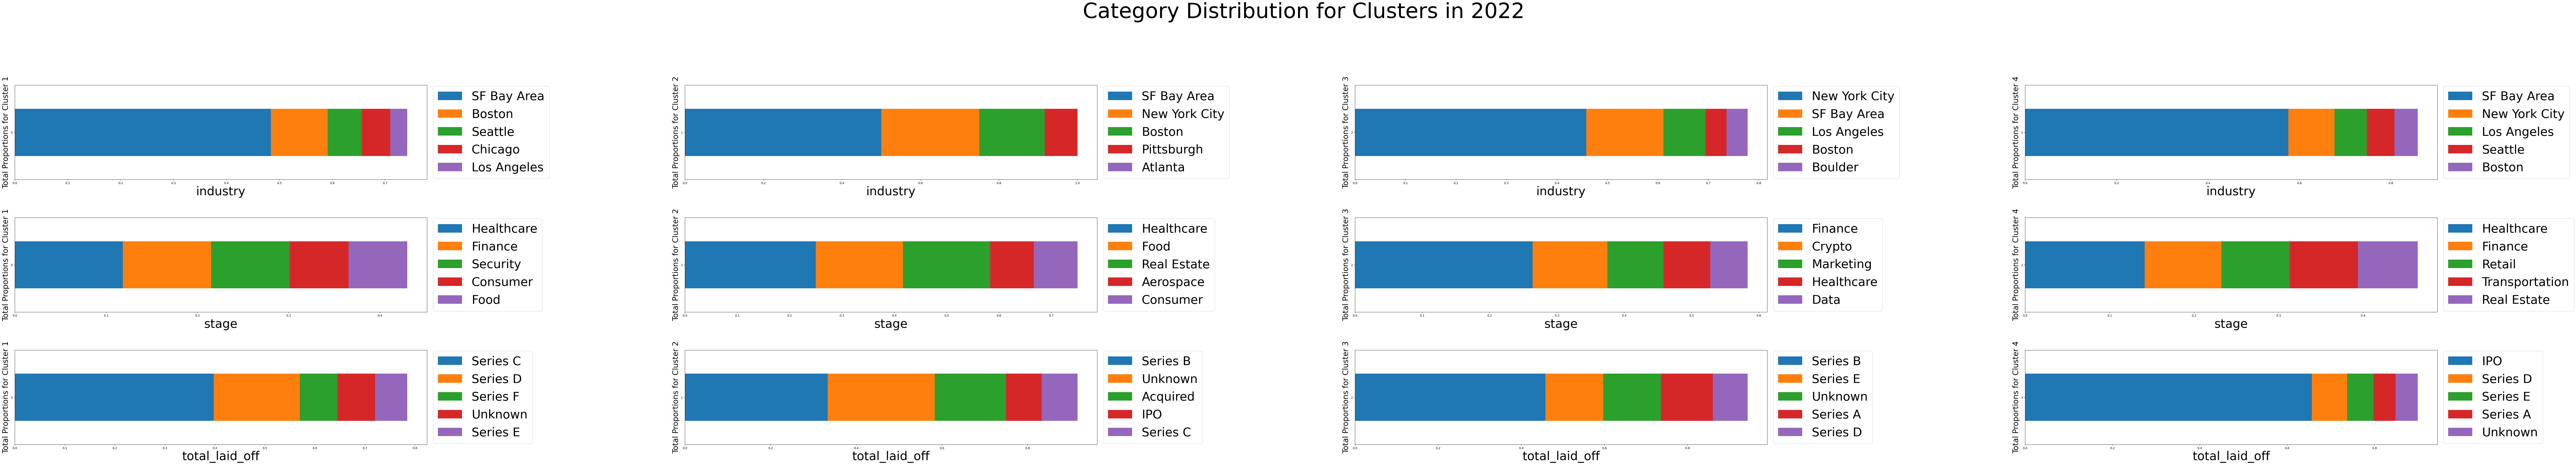

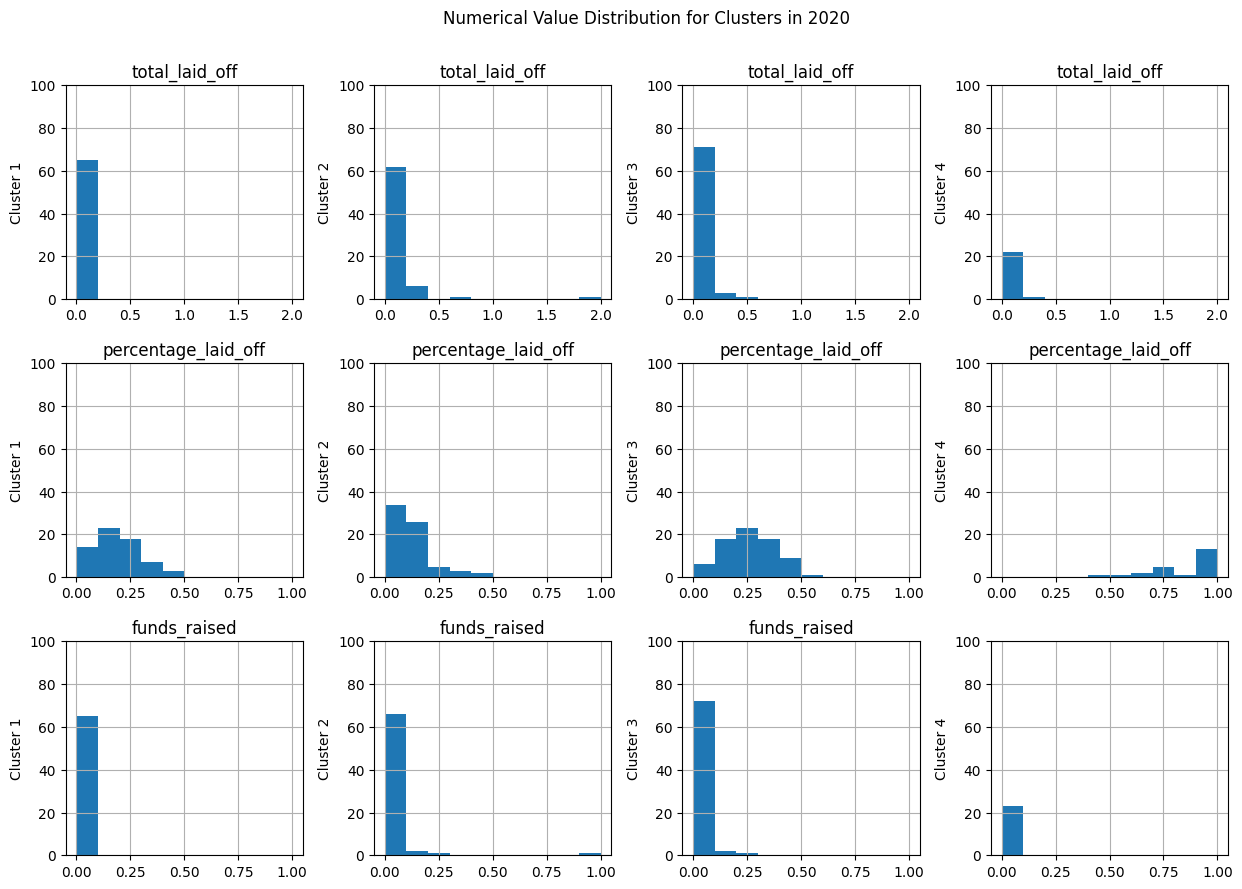

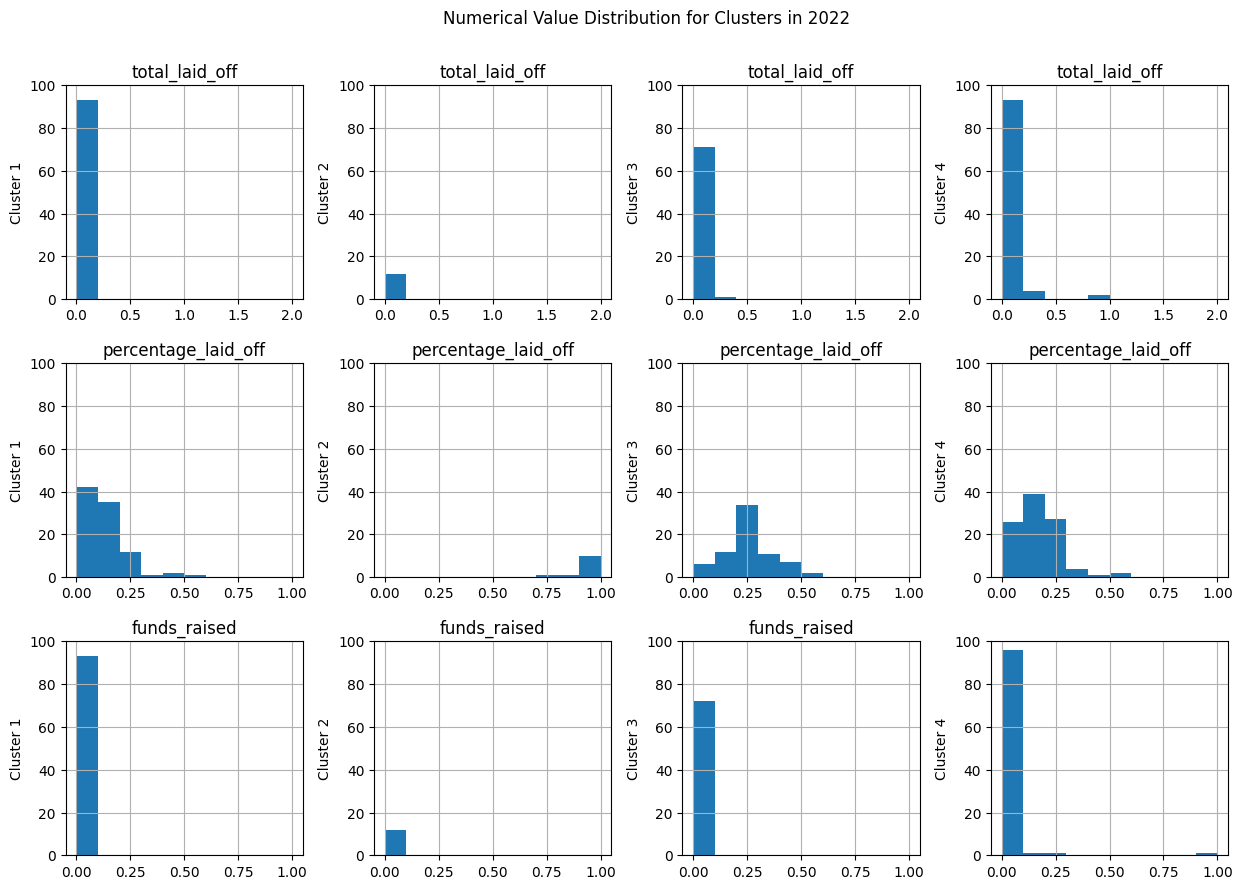

In [896]:
for x in range(2020,2023,2): 
    df_new = clustering(x)
    print(df_new['Cluster Labels'].value_counts())
    fig, ax = plt.subplots(3,4, figsize=(400,400))
    fig.tight_layout(pad=250)
    for i in range(0,3): 
        crosstab = pd.crosstab(index = df_new['Cluster Labels'], columns = df_new.iloc[:,i], normalize='index')
        crosstab_t = crosstab.transpose()
        for y in range(0,4):
            crosstab = pd.crosstab(index = df_new['Cluster Labels'], columns = df_new.iloc[:,i], normalize='index')
            crosstab_t = crosstab.transpose()
            crosstab_t = crosstab_t.nlargest(5, columns = crosstab_t.columns[y])
            crosstab = crosstab_t.transpose()
            crosstab = crosstab.iloc[y]
            crosstab = pd.DataFrame(crosstab)
            crosstab = crosstab.transpose()
            crosstab.plot(ax = ax[i,y], kind='barh', stacked=True, figsize=(135, 20) )
            ax[i,y].legend(loc='center left', bbox_to_anchor=(1, 0.5), prop={'size': 40})
            ax[i,y].set_xlabel('%s' %( df_new.columns[i+1]),fontsize=40)
            ax[i,y].set_ylabel('Total Proportions for Cluster %s' %(y+1),fontsize=25)
    plt.title('Category Distribution for Clusters in %s' %(x), x = -1.75, y= 4.5, loc='center', fontsize=70)
    plt.show()
    
for x in range(2020,2023,2): 
    df_new = clustering(x)
    fig, ax = plt.subplots(3,4, figsize=(15,10))
    for i in range(4): 
        df_new[df_new['Cluster Labels'] == i].hist(ax = ax[0,i],column=df_new.columns[3], figsize=(50,50), range = [0,2])
        ax[0,i].set_ylabel('Cluster %s' %(i+1))
        ax[0,i].set_ylim([0, 100])
    for i in range(4): 
        df_new[df_new['Cluster Labels'] == i].hist(ax = ax[1,i],column=df_new.columns[4], figsize=(50,50), range = [0,1])
        ax[1,i].set_ylabel('Cluster %s' %(i+1))
        ax[1,i].set_ylim([0, 100])
    for i in range(4): 
        df_new[df_new['Cluster Labels'] == i].hist(ax = ax[2,i],column=df_new.columns[5], figsize=(50,50), range = [0,1])
        ax[2,i].set_ylabel('Cluster %s' %(i+1))
        ax[2,i].set_ylim([0, 100])
    plt.title('Numerical Value Distribution for Clusters in %s' %(x), x = -1.45, y= 3.85, loc='center',fontsize=12)

In [897]:
for x in range(2020,2023,2): 
    df_new = clustering(x)
    df_new = df_new.groupby('Cluster Labels').agg(
        {
        'location': lambda x: x.value_counts().index[0],
        'industry': lambda x: x.value_counts().index[0],
        'stage': lambda x: x.value_counts().index[0],
        'total_laid_off': 'mean',
        'percentage_laid_off': 'mean',
        'funds_raised': 'mean'
        }
        ).reset_index()
    display(df_new)

,Cluster Labels,location,industry,stage,total_laid_off,percentage_laid_off,funds_raised
0,0,New York City,Marketing,Series D,0.022713,0.203419,0.007774
1,1,SF Bay Area,Transportation,IPO,0.086823,0.131566,0.031107
2,2,SF Bay Area,Finance,Series B,0.043206,0.270774,0.013277
3,3,SF Bay Area,Food,Series B,0.039997,0.871322,0.002430


,Cluster Labels,location,industry,stage,total_laid_off,percentage_laid_off,funds_raised
0,0,SF Bay Area,Healthcare,Series C,0.010732,0.121290,0.003782
1,1,SF Bay Area,Healthcare,Series B,0.015469,0.963333,0.000821
2,2,New York City,Finance,Series B,0.010219,0.249514,0.002148
3,3,SF Bay Area,Healthcare,IPO,0.059349,0.160758,0.020051


Though K-Prototype defines the cluster leaders' categorical variables as the mode, we can also dig deeper into the distribution of categories for each cluster given the fact that there are varying unique values for the categories of location, industry and stage. The 5 most frequent categories of each of these variables, their relative distribution across the clusters and the number of data points per cluster can also serve to give us insights as to the behaviour of each cluster.  

### 2022 Clusters Analysis 

In 2022, the SF Bay Area and New York are the 2 main locations across all 4 clusters. This is also naturally because a majority of tech companies with reported layoff data in the United States are concentrated within these 2 metropolitan areas. Though there are other locations, we can infer that a majority of the notable cross-cluster differences in layoff characteristics are found in the industry and funding stage as compared to the location. 

In cluster 1, we see that the distribution of industries of companies where layoffs happened that year is spaced out. The funding stages tell us that these classify the companies that are in later stages of raising capital but not yet taken public. We see that cluster 4 also shares the same location and industry with cluster 1 as the most common, however we can deduce that cluster 4 consists of tech companies mainly in SF, in healthcare and also other varying industries, that are in funding stages closer towards their IPO relative to cluster 1. When we look at both the means and distribution of the numercial variables between these 2 cluster, we see that there is also not much dissimilarity in terms of either, with cluster 4 having higher means due to having more outliers with larger values. 

Cluster 2 has the significantly lower number of data points as compared to the other 3. There is no noticeable concentration of 1 or 2 locations, industries or funding stages in this cluster. We see that this cluster stands out in the nature of distribution of the median percentage laid off of employees to the total employees in each company, there is left skew whilst clusters 1 and 4 show a right skew and cluster 3 resembles a normal distribution the most. This means that a bulk of the companies are in the higher end of the percentage laid off, shown also in the relatively higher mean for this variable. Cluster 2 therefore most likely represents the companies that had substantial large proportions of their headcount cut. 

Cluster 3, similar to other clusters have common metropolitan areas as NYC, SF Bay Area, Los Angeles and Boston but also Boulder. This differs from other clusters as this represents more so companies based in New York, we can also find broad differences in the types of industries in this cluster as compared to other clusters. Majority of companies in the other 3 clusters operate in healthcare. Cluster 3 on the other hand, have companies operating in other middleman oriented industries such as Finance, Crypto, Marketing and Data. The distribution of percentage laid off across companies also resemble that of a normal distribution, suggesting that bulk of companies are concentrated around the mean value of 24% since the median will not differ far from the mean.

Summarizing all these takeaways, the clusters can be classified broadly as follows: 

 - Cluster 1 
 
    - Concentrated in SF Bay Area and other common metropolitan areas 
    - Mainly Healthcare, Finance and Security 
    - Mainly later stages of funding but not yet public
    - Lower layoffs, percentage laid off and funds raised per company 
<br> 
 - Cluster 2

    - Concentrated in SF Bay Area and other common metropolitan areas, and Pittsburgh and Atlanta
    - Mainly Healthcare, Food, Real Estate 
    - Mainly later stages of funding
    - Lower layoffs and funds raised but higher average proporton of employees laid off to total headcount per company
<br> 
 - Cluster 3 

    - Concentrated in New York and other common metropolitan areas, and Boulder
    - Mainly Finance, Crypto, Marketing 
    - Mainly later stages of funding but not yet public
    - Lower layoffs and funds raised per company but higher average proportion of emplpyees laid off to total headcount  per company. 
<br> 
 - Cluster 4
 
    - Concentrated in SF Bay Area and other common metropolitan areas
    - Mainly Healthcare, Finance, Retail and Transportation. 
    - Mainly companies that has had an IPO.
    - Higher number of layoffs and funds raised and lower average proportion of employees laid off to headcount

### 2020 Clusters Analysis 

SF Bay Area is a common location across clusters also for our 2020 cohort. Clusters 2, 3 and 4 share this as their most common category for location. We see that cluster 2 has a greater level of funds raised as compared to cluster 3 as well as the magnitude of layoffs which is highest amongst all clusters. Cluster 2 represents largely transportation services with larger financing, that laid off large amounts of employees. Cluster 3 has a higher average percentage laid off, as well as having earlier funding stages. Hence, Cluster 3 represents company in mainly Finance, Healthcare and consumer oriented industries such as Food, Retail and Travel that laid off relatively larger portions of their headcount but with lower actual layoffs.

Cluster 4's most common industries are mainly B2C oriented, and the most common funding stages are earlier stages. The left skew distribution of percentage laid off, and the high mean indicate that this cluster represents tech firms that operate within B2C industries that laid off large portions of their headcount during 2020. 

Cluster 1 has a majority of companies based in New York, and 3 of the top 5 common industries are known for B2B services(Recruiting, Data, Marketing). The distribution funding stages is varied, and has a relatively high mean percentage laid off. Thus this cluster is seen to represent B2B companies mostly based in New York, Boston, LA, Chicago or SF Bay Area that laid off a considerable portion of their headcount in 2020. 

Summarizing all these takeaways, the clusters can be classified broadly as follows: 

 - Cluster 1 

    - Concentrated in New York and other common tech metropolitan areas 
    - Mainly Marketing, Retail, Real Estate
    - Mainly later stages of funding but not yet public
    - Lower layoffs, lower funds raised per company, and higher average proportion of employees laid off to total headcount per companny. 
<br>
 - Cluster 2

    - Concentrated in SF Bay Area and other common tech metropolitan areas, and Salt Lake City
    - Mainly Transportation, Consumer and HR
    - Mainly companies that has had an IPO and later stages of funding
    - Higher layoffs, higher funds raised and higher average proporton of employees laid off to total headcount per company
<br>
 - Cluster 3 

    - Concentrated in SF Bay Area and other common tech metropolitan areas
    - Mainly Finance, Consumer and Healthcare
    - Mainly later stages of funding but not yet public
    - Higher layoff, higher funds raised per company and higher average proportion of emplpyees laid off to total headcount per company. 
<br>
 - Cluster 4
 
    - Concentrated in SF Bay Area and other common tech metropolitan areas, and Denver
    - Mainly Food, Real Estate and Consumer
    - Mainly earlier stages of funding
    - Lower number of layoffs, lower funding and higher average proportion of employees laid off to headcount per company


## Conclusion 

Based on the clusters formed between 2022 and 2020 layoff data per company, we see 2020 clusters have more varying modes for industry compared to 2022. Even though there were varying distributions  in industry for each 2022 cluster, companies that operated in Healthcare were the majority for 3 out of 4 clusters in 2022 showing the disproportionate impact on this industry in particular during tech layoffs for 2022.

Tech layoffs during the COVID period were also more noticeably reported by companies in earlier stages of funding, instead of being concentrated around companies that are in later stages for 2022 layoffs. 

In 2022 across clusters, higher layoff numbers came from companies with larger funding/IPOs. However these companies tended to lay off only lower proportions of their headcounts as compared to non-public companies with lower funding that laid off larger proportions, most likely due to their smaller size. 2020 saw these trends, but also a cluster for companies that were either public or in later stages of funding, that laid off a large number of employees which also was a considerable portion of their workforce. 

This goes to show that compared to this current period of tech layoffs we are facing in 2022, layoffs in 2020 were more broad-based. The economic slowdown during the time affected tech companies irregardless of size and funding stage and across a variety of industries. The layoffs in 2022 on the other hand, has affected mainly tech companies operating in Healthcare and Finance. We also do not yet see high occurences of layoffs from public companies and companies, where large proportions of the workforce are cut like we had seen for 2020. 